***Steps***  
***Part 1: Log Collection/Cleaning***
1. Run `parser.py` file in '/Parsing'. Will parse files in 'rawlogs' into 'cleanlogs'. Creates log_structured.csv and log_templates.csv.
- Example code: `%run parser.py`
2. Use `clean_logs()` to clean log_structured.csv. Rename events to E1, E2 etc., creates log_structured_clean.csv.
- Example code: `clean_logs("./Parsing/cleanlogs/Zookeeper_2k.log_structured.csv","./Parsing/cleanlogs/Zookeeper_2k.log_templates.csv","Zookeeper")`.  
2. 1:  For labeled data use `label_log()` to label your log_structured_clean.csv log into log_labelled.csv. ***Use for HDFS only***
- Example code: `label_log("./Parsing/cleanlogs/HDFS_structured_clean.csv","./Parsing/rawlogs/anomaly_label.csv")`.  
     
***Part 2: Log Parsing and Feature Extraction***  
3. Use `_session_window()` or `_fixed_window()` or `_sliding_window()` to parse and extract events from your log_structured_clean.csv or log_labelled.csv file. ***_session_window() for HDFS only***
- Example code (labelled): `x,y,df = _session_window(data_file="./Parsing/cleanlogs/HDFS_labelled.csv",labels=True)`.  
- Example code: `x,y,df = _fixed_window(data_file="./Parsing/cleanlogs/Zookeeper_structured_clean.csv",windowsize=2,log_type="Zookeeper")`.  
4. Use `_split_data()` to split x,y into training and testing sets.  ***split_type = 'uniform' is only for Labeled Data***.  
- Example code (labeled): = `(x_train,y_train),(x_test,y_test) = _split_data(x,y,train_ratio=0.5,split_type="uniform")`.  
- Example code (unlabeled): `(x_train, _),( x_test, _) = _split_data(x,y=None,train_ratio=0.5,split_type="sequential")`.  


In [82]:
#Parsing and Feature Extraction
import Parsing.clean_parse_extract as cpe
import pandas as pd
import numpy as np
import altair as alt

In [ ]:
#1
#Utilizes Logparser package: IPLoM method
%run parser.py

In [29]:
#2
cpe.clean_logs("./Parsing/cleanlogs/HDFS_2k.log_structured.csv","./Parsing/cleanlogs/HDFS_2k.log_templates.csv","HDFS")

In [30]:
#2.1 *Run on HDFS to get unique blk_ids
cpe.label_log("./Parsing/cleanlogs/HDFS_structured_clean.csv","./Parsing/rawlogs/anomaly_label.csv")

In [126]:
#3
x_hl,y_hl,df_hl = cpe._session_window(data_file="./Parsing/cleanlogs/HDFS_labelled.csv",labels=True)

Number of unique blk_ids:  1994


In [34]:
df_hl.head(3)

,BlockId,EventSequence,Label
0,blk_38865049064139660,[E2],0
1,blk_-6952295868487656571,[E2],0
2,blk_7128370237687728475,[E13],0


In [92]:
#Distribution of Labels
p1 = alt.Chart(df_hl).mark_bar().encode(
    alt.X ("Label:O",scale=alt.Scale(domain = [0,1])),
    alt.Y ("count()"))
text1 = p1.mark_text(
    align='center',
    baseline='bottom',
    dx=0  # Nudges text to right so it doesn't appear on top of the bar
).encode(
    text='count()'
)
p1+text1

alt.LayerChart(...)

In [35]:
#4
(x_train_hl,y_train_hl), (x_test_hl,y_test_hl) = cpe._split_data(x_hl,y_hl,train_ratio = 0.9, split_type = 'uniform')

Size of training set:  227
Size of testing set:  26
Size of total data set:  253
Size of training set:  1794
Size of testing set:  200
Size of total data set:  1994


----
***Part 3: Feature Engineering***  

3. Use `fit_transform()` method from `FeatureExtractor` class to transform the input training data event sequence matrix into an output of transformed data matrix.

- Example code: `x_train = feature_extractor.fit_transform(x_train_hl, term_weighting='tf-idf', normalization='none')`.   

4. Next use `transform()` method from `FeatureExtractor` class to transform the input test data event sequence matrix into an output of transformed data matrix.

- Example code: `x_test = feature_extractor.transform(x_test_hl)`

In [109]:
#For Modelling
from Models.loglizer.loglizer import preprocessing

feature_extractor = preprocessing.FeatureExtractor()

# Transform training set data
x_train = feature_extractor.fit_transform(x_train_hl, term_weighting='tf-idf', 
                                          normalization='mean-zero')
# Transform test set data using model from Training Set
x_test = feature_extractor.transform(x_test_hl)

====== Transformed train data summary ======
Train data shape: 1794-by-14

====== Transformed test data summary ======
Test data shape: 200-by-14



In [124]:
print(x_train[0])
print(x_train_hl[0])

[1.93537498 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
['E10']


In [125]:
print(x_train[1])
print(x_train_hl[1])

[0.         3.11017641 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
['E11']


----
***Part 4: Modeling***  

5. Use `fit()` method for `SVM` and `LR` class objects to use input training data to train SVM model.

- Example code: `mdl_svm.fit(x_train, y_train_hl)`.   


### Supervised Model

In [41]:
# Support Vector Machines
from Models.loglizer.loglizer.models import SVM

mdl_svm = SVM()
mdl_svm.fit(x_train, y_train_hl)

print('Train validation:')
precision, recall, f1 = mdl_svm.evaluate(x_train, y_train_hl)

print('Test validation:')
precision, recall, f1 = mdl_svm.evaluate(x_test, y_test_hl)

====== Model summary ======
Train validation:
====== Evaluation summary ======
Precision: 1.000, recall: 0.066, F1-measure: 0.123

Test validation:
====== Evaluation summary ======
Precision: 1.000, recall: 0.143, F1-measure: 0.250



In [42]:
y_test_pred = mdl_svm.predict(x_test)
y_test_hl[y_test_pred!=y_test_hl]

array([1, 1, 1, 1, 1, 1], dtype=int64)

In [43]:
# Logistic Regression
from Models.loglizer.loglizer.models import LR

mdl_lr = LR()
mdl_lr.fit(x_train, y_train_hl)

print('Train validation:')
precision, recall, f1 = mdl_lr.evaluate(x_train, y_train_hl)

print('Test validation:')
precision, recall, f1 = mdl_lr.evaluate(x_test, y_test_hl)

====== Model summary ======
Train validation:
====== Evaluation summary ======
Precision: 1.000, recall: 0.066, F1-measure: 0.123

Test validation:
====== Evaluation summary ======
Precision: 1.000, recall: 0.143, F1-measure: 0.250



In [44]:
y_test_pred = mdl_lr.predict(x_test)
y_test_hl[y_test_pred!=y_test_hl]

array([1, 1, 1, 1, 1, 1], dtype=int64)

### Result
- This is an imbalanced classification problem. Accuracy will not be a good metric to consider for such data.
- Precision is 100% (for both training and test sets). This shows that for predicted TRUE, proportion of data that are TRUE. Hence all that were predicted true were correct.
- Recall is 14.3% which is quite low. Recall means of the actual TRUE labels, how many were correctly predicted. This metric is quite low.
- F1 score is ver low at 25% which indicates that the model is not working quite well.
- If we observe the misclassified data values, all are the anomalous events that were misclassified.

### Analysis
- This shows that the data provided is not enough to train the model properly.
- Things are aggravated due to high class imbalance. Only 0.03 (3%) of the data events are anomalies that is affecting the results.
- We can improve resulting scores by gathering more data, especially having anomalous events data.

## Unsupervised Model

In [45]:
from Models.loglizer.loglizer.models import PCA

mdl_pca = PCA() 
mdl_pca.fit(x_train)
y_train = mdl_pca.predict(x_train) 

print('Test phase:')
y_test = mdl_pca.predict(x_test)

====== Model summary ======
n_components: 10
Project matrix shape: 14-by-14
SPE threshold: 0.9022704060201758

Test phase:


In [67]:
true_pos = 0
true_neg = 0
false_pos = 0
false_neg = 0
for i in range(0,len(y_train)):
    if (y_train[i] == 1) and (y_train[i] == y_train_hl[i]): #True Positive
        true_pos += 1
    elif (y_train[i] == 0) and (y_train[i] == y_train_hl[i]): #True Negative
        true_neg += 1
    elif (y_train[i] == 1) and (y_train[i] != y_train_hl[i]): #False Positive
        false_pos += 1
    elif (y_train[i] == 0) and (y_train[i] != y_train_hl[i]): #False Positive
        false_neg += 1 
print("Unsupervised Training Accuracy: ", (true_pos+true_neg)/(true_pos+true_neg+false_pos+false_neg))
print("Unsupervised Training Recall: ", (true_pos)/(true_pos+false_neg))
print("Unsupervised Training Precision: ", (true_pos)/(true_pos+false_pos))

Unsupervised Training Accuracy:  0.9671125975473801
Unsupervised Training Recall:  0.06557377049180328
Unsupervised Training Precision:  0.6666666666666666


In [69]:
true_pos = 0
true_neg = 0
false_pos = 0
false_neg = 0
for i in range(0,len(y_test)):
    if (y_test[i] == 1) and (y_test[i] == y_train_hl[i]): #True Positive
        true_pos += 1
    elif (y_test[i] == 0) and (y_test[i] == y_train_hl[i]): #True Negative
        true_neg += 1
    elif (y_test[i] == 1) and (y_test[i] != y_train_hl[i]): #False Positive
        false_pos += 1
    elif (y_test[i] == 0) and (y_test[i] != y_train_hl[i]): #False Positive
        false_neg += 1 
print("Unsupervised Testing Accuracy: ", (true_pos+true_neg)/(true_pos+true_neg+false_pos+false_neg))
print("Unsupervised Testing Recall: ", (true_pos)/(true_pos+false_neg))
print("Unsupervised Testing Precision: ", (true_pos)/(true_pos+false_pos))

Unsupervised Testing Accuracy:  0.97
Unsupervised Testing Recall:  0.0
Unsupervised Testing Precision:  0.0


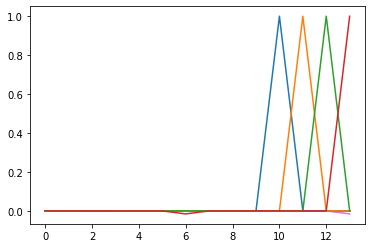

In [108]:
mdl_pca.components
from matplotlib import pyplot as plt
pca_plot = plt.plot()
for i in range(0,len(mdl_pca.proj_C)):
    pca_plot += plt.plot(mdl_pca.proj_C[i])
plt.show(pca_plot)